# Import Libraries

In [205]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.graph_objects as go

import scipy.stats as scs
import statsmodels.stats.api as sms
from math import ceil

import warnings 
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Reading Data

## Data Information

|Column Name|Description|
| --- | --- |
|User ID |Sample of A/B testing. The list is random|
|Timestamp|Timestamp where the A/B testing was taken|
|Group|Treatment and Control|
|Landing Page|Old Page and New Page. New Page for Treatment, Old Page for Control|
|Converted|0 and 1. 0 new landing page did not affect user conversion, 1 new landing page affect user conversion|



## Reading Dataset

In [206]:
dataset_info = {"filename" : "data/ab.csv",
                "separator" : ","}

In [207]:
df = pd.read_csv(dataset_info['filename'], dataset_info['separator'])

In [208]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [210]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


# Data Preparation

## Handling Data Duplication

To ensure that the statistical testing is valid, we have to first ensure there is no duplicates in observations in the sample.

In [211]:
count_of_sessions = df['user_id'].value_counts(ascending=False)
users_duplicated = count_of_sessions[count_of_sessions > 1].count()

print(f'There are {users_duplicated} observations of user that appear multiple time in the dataset.')

There are 3894 observations of user that appear multiple time in the dataset.


Because there are in fact duplication within the data, first we must handle this duplicates.

In [212]:
duplicates_to_drop = count_of_sessions[count_of_sessions > 1].index

df = df[~df['user_id'].isin(duplicates_to_drop)]
print(f'After dropping the duplicated data, now weare left with {df.shape[0]} observations.')

After dropping the duplicated data, now weare left with 286690 observations.


# Statistical Testing: Frequentist Method

## Formulating the Hypothesis

There is two possibility out of this experiment, either the control group perform better than the treatment with statistical significance, or the opposite. Hence, we will use a two-tailed test, where:

$$H_0:p=p_0$$

The **null hypothesis** $H_0$ is the idea that there is no relationship in the population and that the relationship in the sample reflects only sampling error. 

$$H_1:p\ne p_0$$

The **alternative hypothesis** $H_1$ is the idea that there is a relationship in the population and that the relationship in the sample reflects this relationship in the population

Where $p$ and $po$ represent the conversion rate of the control group (old page) and the treatment (new page). Conversion rate is calculated as follow:

$$\text{Conversion Rate}=\frac{\text{Total Converted}}{\text{Total Observations}}$$

For this statistical test, we will use confidence level of 95% or $\alpha$=0.05. This means if the probability of observing a result (p-value) with significant difference is lower than $\alpha$, then we reject the Null hypothesis, or the treatment (new page) can be considered to perform much better than control group (old page) with statistically significance and confidence interval of 95%.

## Calculating Conversion Rate by Group

In [213]:
df_group = df.groupby('group').agg({'user_id':'nunique',
                                    'converted':'sum'}).reset_index()
df_group = df_group.rename(columns={'user_id': 'total_users', 'converted': 'conversions'})
df_group['total_users_pct']=(df_group['total_users']/len(df.index))*100
df_group['conversion_pct']=(df_group['conversions']/df['converted'].sum())*100
df_group['conversion_rate']=(df_group['conversions']/df_group['total_users'])*100
df_group

,group,total_users,conversions,total_users_pct,conversion_pct,conversion_rate
0,control,143293,17220,49.981862,50.284713,12.017335
1,treatment,143397,17025,50.018138,49.715287,11.872633


In [214]:
cvr_control = df_group['conversion_rate'][0]
cvr_treatement = df_group['conversion_rate'][1]
cvr_diff = cvr_control-cvr_treatement

In [215]:
print(f'The conversion rate for Control group is {cvr_control:.2f}%, while the treatment is {cvr_treatement:.2f}% with a difference of {cvr_diff:.2f}%.')

The conversion rate for Control group is 12.02%, while the treatment is 11.87% with a difference of 0.14%.


From the data above, we can see that the conversion rate for Control group is bigger by 0.14% compared to the treatment group.

## Calculating Sample

First, we must know the ideal sample size for us to perform the statistical testing through power analysis.

$$\text{Number of Samples per Group (n)}=\frac{2x(Z_{(1-\alpha)/2}+Z_\beta)^2x\sigma^2}{\Delta^2}$$

Where:
- $\Delta$ = size of difference, minimal effect of interest
- $\alpha$ = Significance level. In this test, we will use 0.05.
- $\beta$ = Power, probability of detecting significant result. In this test, we will use 80%.
- $\sigma$ = Standard deviation of the data
- $Z_p$ = points on normal distribution to give required power and significance.

In [216]:
# Calculating effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.13, 0.15)    

# Calculating sample size required based on alpha=0.05 and power=0.8
required_n = sms.NormalIndPower().solve_power(effect_size, 
                                              power=0.8, 
                                              alpha=0.05, 
                                              ratio=1)
# Rounding up to next whole number
required_n = ceil(required_n)                                                 

print(f'The required sample size for the statistical testing is {required_n}.')

The required sample size for the statistical testing is 4720.


## Sampling the Dataset

We have calculated that we need 4720 observations for each group for this statistical testing. Now, we need to sample our dataste based on the required sample size.

In [225]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test_df = pd.concat([control_sample, treatment_sample], axis=0)
ab_test_df.reset_index(drop=True, inplace=True)

In [226]:
ab_test_df

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [227]:
ab_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [228]:
ab_test_df['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

In [229]:
df_group_sample = ab_test_df.groupby('group').agg({'user_id':'nunique',
                                                   'converted':'sum'}).reset_index()
df_group_sample = df_group_sample.rename(columns={'user_id': 'total_users', 'converted': 'conversions'})
df_group_sample['total_users_pct']=(df_group_sample['total_users']/len(ab_test_df.index))*100
df_group_sample['conversion_pct']=(df_group_sample['conversions']/ab_test_df['converted'].sum())*100
df_group_sample['conversion_rate']=(df_group_sample['conversions']/df_group['total_users'])*100
df_group_sample

,group,total_users,conversions,total_users_pct,conversion_pct,conversion_rate
0,control,4720,582,50.0,49.531915,0.406161
1,treatment,4720,593,50.0,50.468085,0.413537


## Basic Statistical Check

Now, let's check the basic statistic, such as the standard deviation and standard error of each sample.

In [230]:
df_stats = ab_test_df.groupby('group')['converted']

# Std. deviation of the sample
std_p = lambda x: np.std(x, ddof=0)  
# Std. error of the proportion (std / sqrt(n))
se_p = lambda x: scs.sem(x, ddof=0)

df_stats = df_stats.agg([np.mean, std_p, se_p])
df_stats.columns = ['conversion_rate', 'std_deviation', 'std_error']

df_stats

,conversion_rate,std_deviation,std_error
group,,,
control,0.123305,0.328787,0.004786
treatment,0.125636,0.331438,0.004824


In [231]:
cvr_control = (df_stats['conversion_rate'][0])*100
cvr_treatement = (df_stats['conversion_rate'][1])*100
cvr_diff = cvr_control-cvr_treatement

In [232]:
print(f'The conversion rate for Control group is {cvr_control:.2f}%, while the treatment is {cvr_treatement:.2f}% with a difference of {cvr_diff:.2f}%.')

The conversion rate for Control group is 12.33%, while the treatment is 12.56% with a difference of -0.23%.


In this sample, the treatment has a 1.36% higher conversion rate compared to the control group.

## Hypothesis Testing

Now, we move on to see if the difference in conversion rate is statsitically significant by performing hypothesis testing.

In [233]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test_df[ab_test_df['group'] == 'control']['converted']
treatment_results = ab_test_df[ab_test_df['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'confidence interval 95% for control group: [{lower_con*100:.2f}%, {upper_con*100:.2f}%]')
print(f'confidence interval 95% for treatment group: [{lower_treat*100:.2f}%, {upper_treat*100:.2f}%]')

z statistic: -0.34
p-value: 0.732
confidence interval 95% for control group: [11.39%, 13.27%]
confidence interval 95% for treatment group: [11.62%, 13.51%]


## Conclusion

In [234]:
def print_conclusion(pval, alpha=0.05):
    if pval>alpha:
        print(f'Since our p-value={pval:.3f} is bigger than alpha={alpha:.3f}, then we must accept the null hypothesis.')
    else:
        print(f'Since our p-value={pval:.3f} is smaller than alpha={alpha:.3f}, then we can reject the null hypothesis.')

In [235]:
print_conclusion(pval, alpha=0.05)

Since our p-value=0.732 is bigger than alpha=0.050, then we must accept the null hypothesis.


In [236]:
pct_diff = ((cvr_treatement-cvr_control)/cvr_control)*100

In [237]:
print(f'The Treatment group has conversion rate of {pct_diff:.2f}% higher than the Control group.')

The Treatment group has conversion rate of 1.89% higher than the Control group.


## Visualizations

### Required Functions

#### Create Table

In [238]:
def create_plotly_table(data):
    fig = go.Figure(
        data=[
            go.Table(
                header=dict(
                    values=list(data.keys()),
                    line_color="white",
                    fill_color="white",
                    font=dict(size=12, color="black"),
                    align="left",
                ),
                cells=dict(
                    values=[data.get(k) for k in data.keys()],
                    align="left",
                    fill=dict(color=[["#F9F9F9", "#FFFFFF"] * 5]),
                ),
            )
        ]
    )

    fig.update_layout(
        autosize=False,
        height=150,
        margin=dict(
            l=20,
            r=20,
            b=10,
            t=30,
        ),
    )

    fig.show()

#### Get Statistics

In [239]:
def get_stats(visitors_A, visitors_B, conversions_A, conversions_B):
    control_cr = conversions_A / visitors_A
    variant_cr = conversions_B / visitors_B
    relative_difference = variant_cr / control_cr - 1
    control_se = (control_cr * (1 - control_cr) / visitors_A) ** 0.5
    variant_se = (variant_cr * (1 - variant_cr) / visitors_B) ** 0.5
    se_difference = (control_se ** 2 + variant_se ** 2) ** 0.5
    return control_cr, variant_cr, relative_difference, control_se, variant_se, se_difference
    

#### Get Power

In [240]:
def get_power(visitors_A, visitors_B, conversions_A, conversions_B, alpha=0.05, two_tails=True):
    """Returns observed power from test results."""
    
    control_cr, variant_cr, relative_difference, control_se, variant_se, se_difference = get_stats(visitors_A, visitors_B, conversions_A, conversions_B)
    
    n = visitors_A + visitors_B
    
    if two_tails:
        qu = scs.norm.ppf(1 - alpha / 2)
    else:
        qu = scs.norm.ppf(1 - alpha)

    diff = abs(variant_cr - control_cr)
    avg_cr = (control_cr + variant_cr) / 2

    control_var = control_cr * (1 - control_cr)
    variant_var = variant_cr * (1 - variant_cr)
    avg_var = avg_cr * (1 - avg_cr)

    power_lower = scs.norm.cdf(
        (n ** 0.5 * diff - qu * (2 * avg_var) ** 0.5)
        / (control_var + variant_var) ** 0.5
        )
    power_upper = 1 - scs.norm.cdf(
        (n ** 0.5 * diff + qu * (2 * avg_var) ** 0.5)
        / (control_var + variant_var) ** 0.5
        )

    power = power_lower + power_upper

    return power

#### Get Z Value

In [241]:
def get_z_value(alpha=0.05, two_tails=True):
    z_dist = scs.norm()
    if two_tails:
        alpha = alpha / 2
        area = 1 - alpha
    else:
        area = 1 - alpha

    z = z_dist.ppf(area)
    return z

#### Get Tail Direction

In [242]:
def get_tail_directions(relative_difference, two_tails=True):
    if two_tails is False:
            if relative_difference < 0:
                tail_direction = "right"
            else:
                tail_direction = "left"
    else:
        tail_direction = "two"
    return tail_direction

#### Z_Test

In [243]:
def z_test(visitors_A,visitors_B,conversions_A,conversions_B,alpha,two_tails=True):
        """Run a Z-test with your data, returning the Z-score and p-value.
        Returns
        -------
        z_score : float
            Number of standard deviations between the mean of the control
            conversion rate distribution and the variant conversion rate
        p_value : float
            Probability of obtaining test results at least as extreme as the
            observed results, under the conditions of the null hypothesis
        """
        # get stats, z, power, tail direction
        control_cr, variant_cr, relative_difference, control_se, variant_se, se_difference = get_stats(visitors_A, visitors_B, conversions_A, conversions_B)
        power = get_power(visitors_A, visitors_B, conversions_A, conversions_B)
        tail_direction = get_tail_directions(relative_difference, two_tails)
        
        combined_cr = (conversions_A + conversions_B) / (
            visitors_A + visitors_B
        )
        combined_se = (
            combined_cr
            * (1 - combined_cr)
            * (1 / visitors_A + 1 / visitors_B)
        ) ** 0.5

        # z-score
        z_score = (variant_cr - control_cr) / combined_se

        # Calculate the p-value dependent on one or two tails
        if tail_direction == "left":
            p_value = scs.norm.cdf(-z_score)
        elif tail_direction == "right":
            p_value = scs.norm.cdf(z_score)
        else:
            p_value = 2 * scs.norm.cdf(-abs(z_score))

        return z_score, p_value

#### Z-test Visualizations

In [244]:
def plot_test_visualisation(visitors_A,visitors_B,conversions_A,conversions_B,alpha,two_tails=True):
        """Plots a visualisation of the Z test and its results."""
        
        # Set fonts
        reg_text = {"size": "12"}
        text_title = {"size": "14", "weight": "bold"}
        text_bold = {"size": "12", "weight": "bold"}
        text_small = {"size": "10"}
        
        # get stats, z, power, tail direction
        control_cr, variant_cr, relative_difference, control_se, variant_se, se_difference = get_stats(visitors_A, visitors_B, conversions_A, conversions_B)
        z = get_z_value(alpha, two_tails)
        power = get_power(visitors_A, visitors_B, conversions_A, conversions_B)
        tail_direction = get_tail_directions(relative_difference, two_tails)

        fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
        xA = np.linspace(0 - 4 * se_difference, 0 + 4 * se_difference, 1000)
        yA = scs.norm(0, se_difference).pdf(xA)
        ax.plot(xA, yA, c="#181716")

        diff = variant_cr - control_cr

        ax.axvline(
            x=diff, ymax=ax.get_ylim()[1], c="tab:orange", alpha=0.5, linestyle="--"
        )
        ax.text(
            ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.8,
            ax.get_ylim()[1] * 0.8,
            "Observed\ndifference: {:.2%}".format(relative_difference),
            color="tab:orange",
            **reg_text,
        )

        if tail_direction == "left":
            ax.fill_between(
                xA,
                0,
                yA,
                where=(xA > 0 + se_difference * z),
                color="green",
                alpha=0.2,
            )
        elif tail_direction == "right":
            ax.fill_between(
                xA,
                0,
                yA,
                where=(xA < 0 - se_difference * z),
                color="green",
                alpha=0.2,
            )
        else:
            ax.fill_between(
                xA,
                0,
                yA,
                where=(xA > 0 + se_difference * z)
                | (xA < 0 - se_difference * z),
                color="green",
                alpha=0.2,
            )

        ax.get_xaxis().set_major_formatter(
            mtick.FuncFormatter(lambda x, p: format(x / control_cr, ".0%"))
        )

        plt.xlabel("Relative difference of the means")

        ax.text(
            ax.get_xlim()[0],
            ax.get_ylim()[1] * 1.25,
            "Z-test visualisation",
            **text_title,
        )

        ax.text(
            ax.get_xlim()[0],
            ax.get_ylim()[1] * 1.18,
            "Displays the expected distribution of the difference between the"
            " means under the null hypothesis.",
            **reg_text,
        )

        sns.despine(left=True)
        ax.get_yaxis().set_visible(False)
        fig.tight_layout()

        plt.show()

#### Power Plot

In [245]:
def plot_power(visitors_A,visitors_B,conversions_A,conversions_B,alpha,two_tails=True):
        """Returns a plot figure visualising Power based on the
        results of an AB test."""
        
        # Set fonts
        reg_text = {"size": "12"}
        text_title = {"size": "14", "weight": "bold"}
        text_bold = {"size": "12", "weight": "bold"}
        text_small = {"size": "10"}
        
        # get stats, z, power, tail direction
        control_cr, variant_cr, relative_difference, control_se, variant_se, se_difference = get_stats(visitors_A, visitors_B, conversions_A, conversions_B)
        z = get_z_value(alpha, two_tails)
        power = get_power(visitors_A, visitors_B, conversions_A, conversions_B)
        tail_direction = get_tail_directions(relative_difference, two_tails)
        
        fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
        
        # Plot the distribution of A
        xA = np.linspace(
            control_cr - 4 * control_se,
            control_cr + 4 * control_se,
            1000,
        )
        yA = scs.norm(control_cr, control_se).pdf(xA)
        ax.plot(xA, yA, label="A")

        # Plot the distribution of B
        xB = np.linspace(
            variant_cr - 4 * variant_se,
            variant_cr + 4 * variant_se,
            1000,
        )
        yB = scs.norm(variant_cr, variant_se).pdf(xB)
        ax.plot(xB, yB, label="B")

        # Label A at its apex
        ax.text(
            control_cr,
            max(yA) * 1.03,
            "A",
            color="tab:blue",
            horizontalalignment="center",
            **text_bold,
        )

        # Label B at its apex
        ax.text(
            variant_cr,
            max(yB) * 1.03,
            "B",
            color="tab:orange",
            horizontalalignment="center",
            **text_bold,
        )

        # Add critical value lines depending on two vs. one tail and left vs. right
        if tail_direction == "left":
            ax.axvline(
                x=control_cr + control_se * z,
                c="tab:blue",
                alpha=0.5,
                linestyle="--",
            )
            ax.text(
                control_cr + control_se * z,
                max(yA) * 0.4,
                "Critical value",
                color="tab:blue",
                rotation=270,
                **text_small,
            )
        elif tail_direction == "right":
            ax.axvline(
                x=control_cr - control_se * z,
                c="tab:blue",
                alpha=0.5,
                linestyle="--",
            )
            ax.text(
                scontrol_cr - control_se * z,
                max(yA) * 0.4,
                "Critical value",
                color="tab:blue",
                rotation=270,
                **text_small,
            )
        else:
            ax.axvline(
                x=control_cr - control_se * z,
                c="tab:blue",
                alpha=0.5,
                linestyle="--",
            )
            ax.text(
                control_cr - control_se * z,
                max(yA) * 0.4,
                "Critical value",
                color="tab:blue",
                rotation=270,
                **text_small,
            )

            ax.axvline(
                x=control_cr + control_se * z,
                c="tab:blue",
                alpha=0.5,
                linestyle="--",
            )
            ax.text(
                control_cr + control_se * z,
                max(yA) * 0.4,
                "Critical value",
                color="tab:blue",
                rotation=270,
                **text_small,
            )

        # Fill in the power and annotate
        if variant_cr > control_cr:
            ax.fill_between(
                xB,
                0,
                yB,
                where=(xB > control_cr + control_se * z),
                color="green",
                alpha=0.2,
            )
        else:
            ax.fill_between(
                xB,
                0,
                yB,
                where=(xB < control_cr - control_se * z),
                color="green",
                alpha=0.2,
            )

        # Display power value on graph
        ax.text(
            ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.8,
            ax.get_ylim()[1] * 0.8,
            f"Power: {power:.2%}",
            horizontalalignment="left",
            **reg_text,
        )

        # Title
        ax.text(
            ax.get_xlim()[0],
            ax.get_ylim()[1] * 1.25,
            "Statistical power",
            **text_title,
        )

        # Subtitle
        ax.text(
            ax.get_xlim()[0],
            ax.get_ylim()[1] * 1.17,
            "Illustrates the likelihood of avoiding a false negative/type II" " error",
            **reg_text,
        )

        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
        plt.xlabel("Converted Proportion")

        sns.despine(left=True)
        ax.get_yaxis().set_visible(False)
        fig.tight_layout()

        plt.show()

#### Get Table Data

In [247]:
def get_table_data(visitors_A,visitors_B,conversions_A,conversions_B,alpha,two_tails=True):
    # Set fonts
    reg_text = {"size": "12"}
    text_title = {"size": "14", "weight": "bold"}
    text_bold = {"size": "12", "weight": "bold"}
    text_small = {"size": "10"}
        
    # get stats, z, power, tail direction
    control_cr, variant_cr, relative_difference, control_se, variant_se, se_difference = get_stats(visitors_A, visitors_B, conversions_A, conversions_B)
    z = get_z_value(alpha, two_tails)
    power = get_power(visitors_A, visitors_B, conversions_A, conversions_B)
    tail_direction = get_tail_directions(relative_difference, two_tails)
    z_score, p_value = z_test(visitors_A,visitors_B,conversions_A,conversions_B,alpha,two_tails)
    
    data = {"<b>Variant</b>": ["A", "B"],
            "<b>Visitors</b>": [f"{visitors_A:,}", f"{visitors_B:,}"],
            "<b>Conversions</b>": [conversions_A, conversions_B],
            "<b>Conversion rate</b>": [f"{control_cr:.2%}", f"{variant_cr:.2%}"],
            "<b>Uplift</b>": ["", f"{relative_difference:.2%}"],
            "<b>Power</b>": ["", f"{power:.4f}"],
            "<b>Z-score</b>": ["", f"{z_score:.4f}"],
            "<b>P-value</b>": ["", f"{p_value:.4f}"],
           }
    return data

#### Get Table for Dashboard

In [248]:
def get_table_dash(visitors_A,visitors_B,conversions_A,conversions_B,alpha,two_tails=True):
    # Set fonts
    reg_text = {"size": "12"}
    text_title = {"size": "14", "weight": "bold"}
    text_bold = {"size": "12", "weight": "bold"}
    text_small = {"size": "10"}
        
    # get stats, z, power, tail direction
    control_cr, variant_cr, relative_difference, control_se, variant_se, se_difference = get_stats(visitors_A, visitors_B, conversions_A, conversions_B)
    z = get_z_value(alpha, two_tails)
    power = get_power(visitors_A, visitors_B, conversions_A, conversions_B)
    tail_direction = get_tail_directions(relative_difference, two_tails)
    z_score, p_value = z_test(visitors_A,visitors_B,conversions_A,conversions_B,alpha,two_tails)
    
    result_dict = {'Control':{'Visitors':visitors_A,
                          'Conversions':conversions_A,
                          'Conversion Rate':control_cr,
                          'Uplift':'',
                          'Power':'',
                          'Z-score':'',
                          'P-value':''},
                   'Treatment':{'Visitors':visitors_B,
                                'Conversions':conversions_B,
                                'Conversion Rate':variant_cr,
                                'Uplift':relative_difference,
                                'Power':power,
                                'Z-score':z_score,
                                'P-value':p_value}}
    return result_dict

## Visualizations within the Notebook

In [249]:
visitors_A = control_sample['user_id'].nunique()
visitors_B = treatment_sample['user_id'].nunique()
conversions_A = control_sample['converted'].sum()
conversions_B = treatment_sample['converted'].sum()

In [250]:
alpha = 0.05
two_tails = True

### Show A/B Test Result as Table

In [251]:
data = get_table_data(visitors_A,visitors_B,conversions_A,conversions_B,alpha,two_tails)

In [252]:
create_plotly_table(data)

### Z-test Visualizations

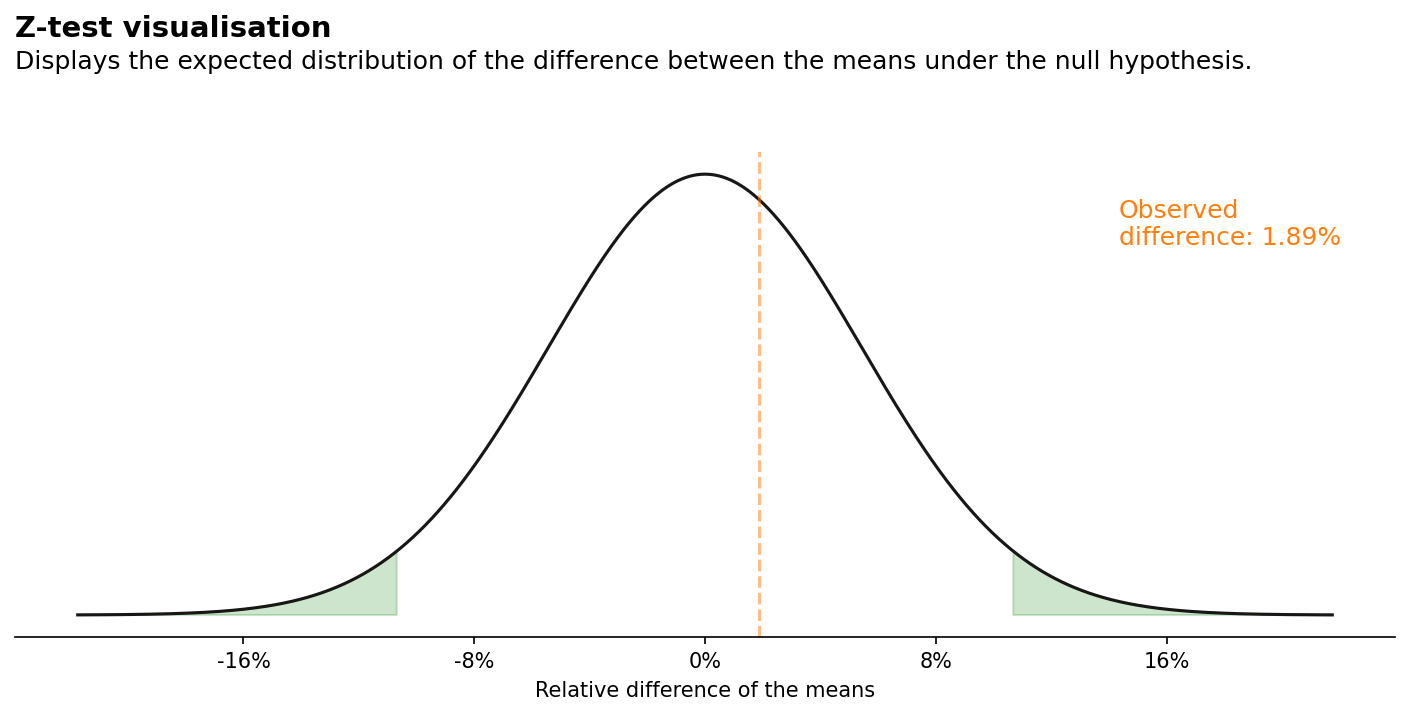

In [253]:
plot_test_visualisation(visitors_A,visitors_B,conversions_A,conversions_B,alpha,two_tails)

### Power Plot

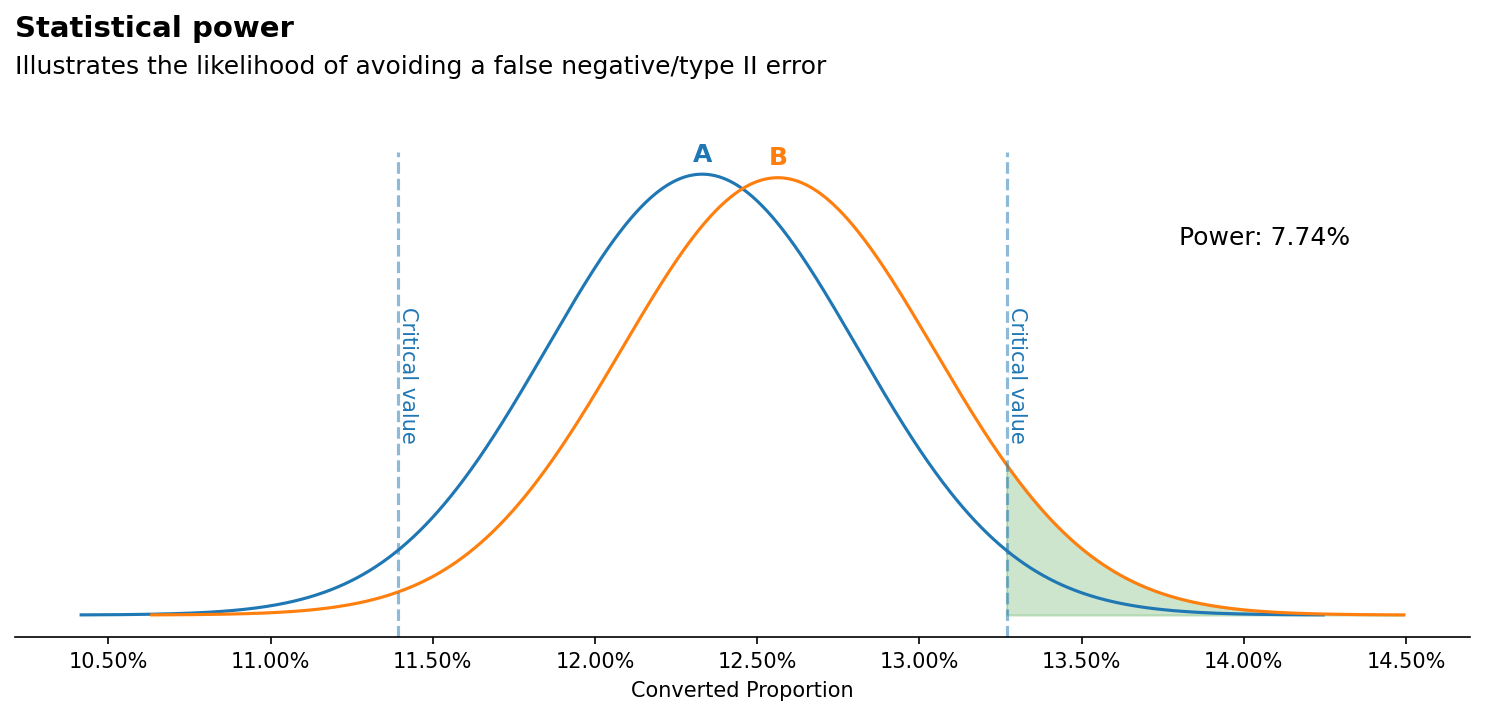

In [254]:
plot_power(visitors_A,visitors_B,conversions_A,conversions_B,alpha,two_tails)

## Data for Dashboard

## Result Table

In [255]:
result_dict = get_table_dash(visitors_A,visitors_B,conversions_A,conversions_B,alpha,two_tails)
result_df = pd.DataFrame.from_dict(result_dict, orient='index')

In [256]:
result_df

,Visitors,Conversions,Conversion Rate,Uplift,Power,Z-score,P-value
Control,4720,582,0.123305,,,,
Treatment,4720,593,0.125636,0.0189003,0.0773544,0.342956,0.731632


### Z-Test Plot

In [260]:
# get stats, z, power, tail direction
control_cr, variant_cr, relative_difference, control_se, variant_se, se_difference = get_stats(visitors_A, visitors_B, conversions_A, conversions_B)
z = get_z_value(alpha, two_tails)
power = get_power(visitors_A, visitors_B, conversions_A, conversions_B)

In [261]:
xA_z_test = np.linspace(0 - 4 * se_difference, 0 + 4 * se_difference, 1000)
yA_z_test = scs.norm(0, se_difference).pdf(xA_z_test)
df_z_test = pd.DataFrame({'x':xA_z_test, 'y':yA_z_test})
df_z_test['diff']=variant_cr - control_cr
df_z_test['observed_diff']=relative_difference

In [262]:
df_z_test

,x,y,diff,observed_diff
0,-0.027181,0.019694,0.002331,0.0189
1,-0.027127,0.020335,0.002331,0.0189
2,-0.027072,0.020995,0.002331,0.0189
3,-0.027018,0.021675,0.002331,0.0189
4,-0.026964,0.022375,0.002331,0.0189
...,...,...,...,...
995,0.026964,0.022375,0.002331,0.0189
996,0.027018,0.021675,0.002331,0.0189
997,0.027072,0.020995,0.002331,0.0189
998,0.027127,0.020335,0.002331,0.0189


### Power Plot

In [269]:
xA_power = np.linspace(control_cr - 4 * control_se,control_cr + 4 * control_se,1000,)
yA_power = scs.norm(control_cr, control_se).pdf(xA_power)
xB_power = np.linspace(variant_cr - 4 * variant_se,variant_cr + 4 * variant_se,1000,)
yB_power = scs.norm(variant_cr, variant_se).pdf(xB_power)
crit_val_min = control_cr - control_se * z
crit_val_max = control_cr + control_se * z

In [270]:
power_dict_x = {'Control':{'x':xA_power},'Treatment':{'x':xB_power}}
power_dict_y = {'Control':{'y':yA_power},'Treatment':{'y':yB_power}}
power_df_x = pd.DataFrame.from_dict(power_dict_x, orient='index')
power_df_y = pd.DataFrame.from_dict(power_dict_y, orient='index')

In [271]:
power_df_x = power_df_x.explode('x')
power_df_y = power_df_y.explode('y')
df_power = pd.concat([power_df_x, power_df_y], axis=1, join="inner")

In [276]:
df_power

,x,y
Control,0.104162,0.0279647
Control,0.104201,0.0288741
Control,0.104239,0.0298111
Control,0.104277,0.0307765
Control,0.104316,0.0317712
...,...,...
Treatment,0.144778,0.031517
Treatment,0.144817,0.0305303
Treatment,0.144855,0.0295726
Treatment,0.144894,0.0286431


In [277]:
df_power_crit = power_df_y.copy()
df_power_crit['crit_val_min'] = crit_val_min
df_power_crit['crit_val_max'] = crit_val_max

In [278]:
df_power_crit

,y,crit_val_min,crit_val_max
Control,0.0279647,0.113925,0.132685
Control,0.0288741,0.113925,0.132685
Control,0.0298111,0.113925,0.132685
Control,0.0307765,0.113925,0.132685
Control,0.0317712,0.113925,0.132685
...,...,...,...
Treatment,0.031517,0.113925,0.132685
Treatment,0.0305303,0.113925,0.132685
Treatment,0.0295726,0.113925,0.132685
Treatment,0.0286431,0.113925,0.132685


### Download Results

In [284]:
ab_test_df.to_csv('ab_sample.csv')

In [285]:
result_df.to_csv('ab_result_table.csv')

In [286]:
df_z_test.to_csv('ab_z_test.csv')

In [287]:
df_power.to_csv('ab_power.csv')

In [288]:
df_power_crit.to_csv('ab_power_crit.csv')